In [96]:
import pandas as pd
from underthesea import word_tokenize
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from DatabaseConnect import *
import warnings
warnings.simplefilter("ignore")

conn = connect()

{'host': 'localhost', 'database': 'phamkimhoang', 'user': 'postgres', 'password': 'postgres'}
Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 15.1 on aarch64-apple-darwin21.6.0, compiled by Apple clang version 14.0.0 (clang-1400.0.29.102), 64-bit',)


In [97]:
frequent = 7
sql = "select * from tbdatamodel where frequent=" + str(frequent) + " order by newsdate desc"
df_model = pd.read_sql_query(sql, conn)
df_model

,newsdate,title_tokenized,label,frequent
0,2023-02-10,nhóm quỹ dragon capital tiếp tục gom stb khiến...,1.0,7.0
1,2023-02-09,dòng tiền thông minh nđt cá nhân bán ròng hơn ...,1.0,7.0
2,2023-02-08,góc nhìn kỹ thuật phiên giao dịch chứng khoán ...,0.0,7.0
3,2023-02-07,các kịch bản biến động vnindex năm thị trường ...,0.0,7.0
4,2023-02-06,vì sao thị trường rung lắc mạnh lãi suất tăng ...,0.0,7.0
...,...,...,...,...
3367,2009-06-05,khát nhân sự ngành chứng khoán lợi nhuận ngân ...,0.0,7.0
3368,2009-06-04,doanh nghiệp vừa nhỏ vẫn nơm nớp lo tỷ giá niê...,1.0,7.0
3369,2009-06-03,vàng sơ chế ở nước ngoài phép chuyển về việt n...,1.0,7.0
3370,2009-06-02,lãi suất huy động usd giảm sâu trào lưu niêm y...,1.0,7.0


In [66]:
df_model['label'].value_counts()

1.0    1919
0.0    1453
Name: label, dtype: int64

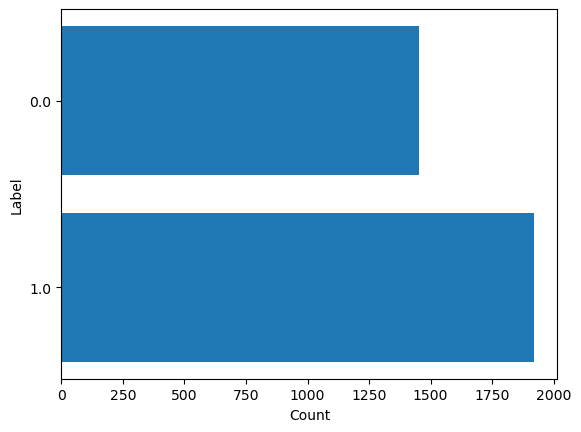

In [98]:
df_label = pd.DataFrame(df_model['label'].value_counts())
df_label.index = df_label.index.astype(str)

plt.barh(df_label.index, df_label['label'])
plt.xlabel('Count')
plt.ylabel('Label')

plt.show()

<h1>TfidfVectorizer</h1>

In [99]:
text_data = df_model[['title_tokenized']]
text_data = text_data.apply(lambda x: " ".join(str(x) for x in x), axis=1)

# perform count vectorization to convert text into numerical data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_data)
y = df_model["label"]
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aam', ..., 'ủy', 'ức', 'ứng'], dtype=object)

In [100]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test

In [70]:
models = [GaussianNB(), LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier()]
model_names = ["Naive Bayes", "Logistic Regression", "Support Vector Classifier", "Random Forest", "Gradient Boosting", "K-Nearest Neighbors", "Decision Tree"]

# models = [LogisticRegression(), SVC()]
# model_names = ["Logistic Regression", "Support Vector Classifier"]

results=[]
reports=[]
cross_score_accuracy = []
cross_score_f1 = []
# Train each model and get predictions
for model, model_name in zip(models, model_names):
    model.fit(train_data.toarray(), train_labels)
    predictions = model.predict(test_data.toarray())
    
    # Calculate evaluation metrics for each model
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    if model_name == 'Naive Bayes':
        scores = cross_val_score(model, X.toarray(), y, cv=10, scoring='accuracy')
        scores_f1 = cross_val_score(model, X.toarray(), y, cv=10, scoring='f1')
    else:
        scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        scores_f1 = cross_val_score(model, X, y, cv=10, scoring='f1')

    results.append((model_name, accuracy, precision, recall, f1))
    reports.append(classification_report(test_labels, predictions))
    cross_score_accuracy.append(scores)
    cross_score_f1.append(scores_f1)

In [71]:
# Print the results
df_result = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
for result in results:
    row = pd.DataFrame({"Model": [result[0]], "Accuracy": [result[1]*100], "Precision": [result[2]*100], "Recall": [result[3]*100], "F1 Score": [result[4]*100]})
    df_result = pd.concat([df_result, row], ignore_index=True)

df_result.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
1,Logistic Regression,62.962963,65.039062,82.425743,72.707424
2,Support Vector Classifier,62.222222,63.279857,87.871287,73.575130
3,Random Forest,60.148148,62.385321,84.158416,71.654373
5,K-Nearest Neighbors,60.000000,67.357513,64.356436,65.822785
4,Gradient Boosting,58.666667,61.682243,81.683168,70.287540
6,Decision Tree,50.222222,59.042553,54.950495,56.923077
0,Naive Bayes,46.962963,60.952381,31.683168,41.693811


In [72]:
cross_score_accuracy

[array([0.44970414, 0.50295858, 0.45697329, 0.51632047, 0.46884273,
        0.44807122, 0.45994065, 0.44510386, 0.4272997 , 0.4925816 ]),
 array([0.56804734, 0.53846154, 0.55192878, 0.52522255, 0.50148368,
        0.45994065, 0.35311573, 0.5074184 , 0.45103858, 0.46290801]),
 array([0.54733728, 0.54142012, 0.55192878, 0.53709199, 0.52225519,
        0.47181009, 0.3620178 , 0.52225519, 0.46290801, 0.44510386]),
 array([0.56804734, 0.5591716 , 0.56973294, 0.53115727, 0.53412463,
        0.46884273, 0.3768546 , 0.48664688, 0.48961424, 0.47774481]),
 array([0.5739645 , 0.56213018, 0.55192878, 0.51928783, 0.49851632,
        0.51038576, 0.36795252, 0.50148368, 0.52818991, 0.48664688]),
 array([0.52071006, 0.51183432, 0.50445104, 0.4925816 , 0.4272997 ,
        0.48664688, 0.39169139, 0.51632047, 0.49554896, 0.47477745]),
 array([0.57100592, 0.54733728, 0.47477745, 0.52225519, 0.49554896,
        0.50148368, 0.42433234, 0.50445104, 0.54005935, 0.46884273])]

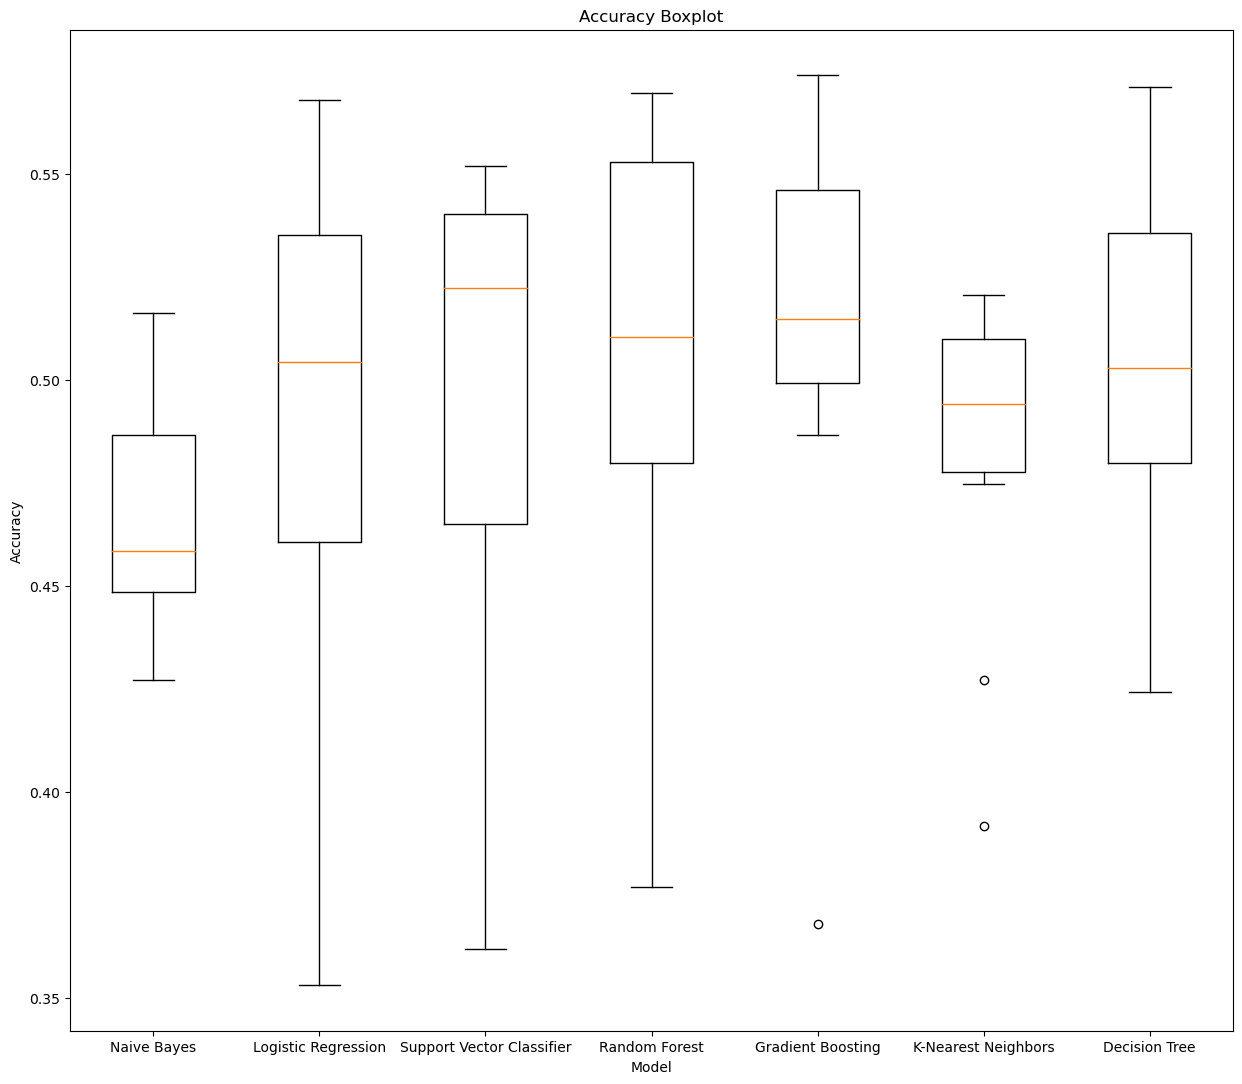

In [73]:
fig, ax = plt.subplots(figsize=(15, 13))
ax.boxplot(cross_score_accuracy)
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(model_names)
ax.set_title("Accuracy Boxplot")

# Show the plot
plt.show()

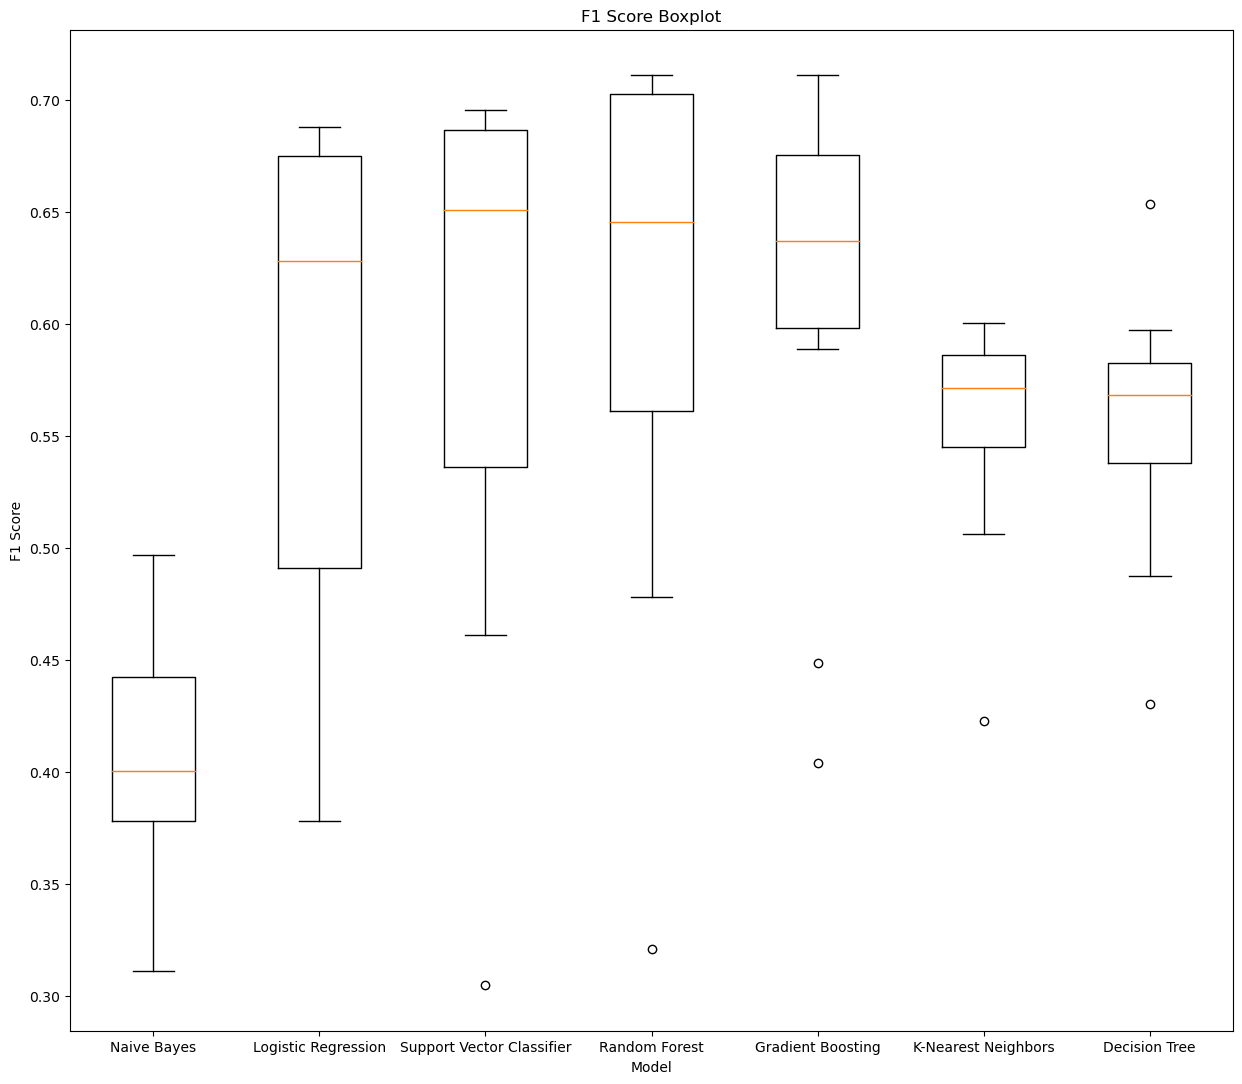

In [74]:
fig, ax = plt.subplots(figsize=(15, 13))
ax.boxplot(cross_score_f1)
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(model_names)
ax.set_title("F1 Score Boxplot")

# Show the plot
plt.show()

Text(0.5, 1.0, 'F1 Score Boxplot')

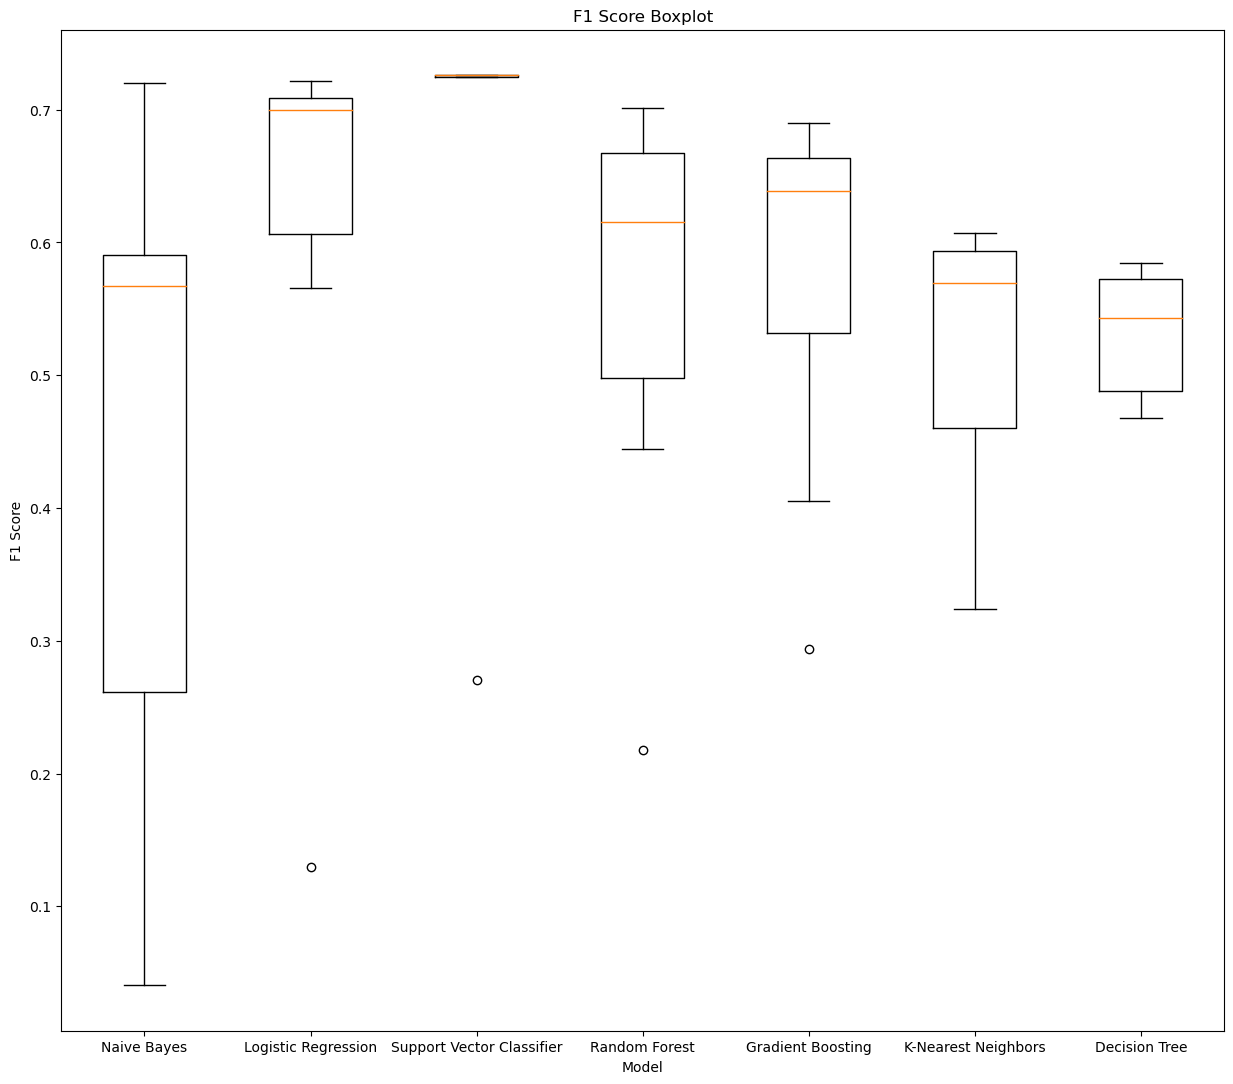

In [87]:
fig, ax = plt.subplots(figsize=(15, 13))
ax.boxplot(cross_score_f1)
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(model_names)
ax.set_title("F1 Score Boxplot")

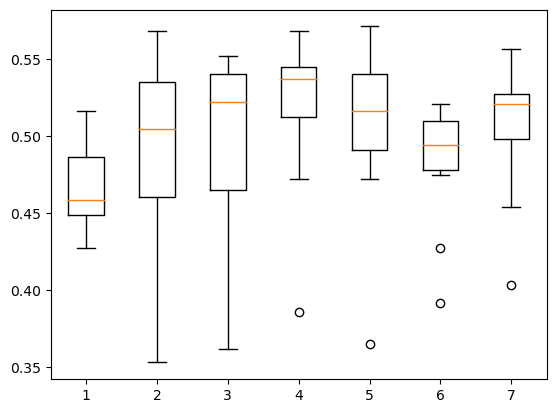

In [75]:
import matplotlib.pyplot as plt

data = [
    [0.44970414, 0.50295858, 0.45697329, 0.51632047, 0.46884273, 0.44807122, 0.45994065, 0.44510386, 0.4272997 , 0.4925816 ],
    [0.56804734, 0.53846154, 0.55192878, 0.52522255, 0.50148368, 0.45994065, 0.35311573, 0.5074184 , 0.45103858, 0.46290801],
    [0.54733728, 0.54142012, 0.55192878, 0.53709199, 0.52225519, 0.47181009, 0.3620178 , 0.52225519, 0.46290801, 0.44510386],
    [0.56804734, 0.54142012, 0.54599407, 0.53412463, 0.54599407, 0.51038576, 0.38575668, 0.54005935, 0.51928783, 0.47181009],
    [0.57100592, 0.5443787 , 0.54896142, 0.52818991, 0.49554896, 0.47181009, 0.36498516, 0.51335312, 0.51928783, 0.48961424],
    [0.52071006, 0.51183432, 0.50445104, 0.4925816 , 0.4272997 , 0.48664688, 0.39169139, 0.51632047, 0.49554896, 0.47477745],
    [0.55621302, 0.54733728, 0.52818991, 0.52522255, 0.4925816 , 0.51335312, 0.40356083, 0.51928783, 0.52225519, 0.45400593]
]

plt.boxplot(data)
plt.show()


In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# define the parameter grid
param_grid =  {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': [randint(2, 20)],
    'min_samples_leaf': [randint(1, 20)],
    'bootstrap': [True, False]
}

# create a random forest classifier
rfc = RandomForestClassifier()

# create a grid search object
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
# print the best parameters found
print("Best parameters: ", grid_search.best_params_)
print("classification_report")
print(classification_report(y_test, y_pred))


Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff4b2f22e80>, min_samples_split=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff4b2f46760>, n_estimators=50; total time=   0.0s[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9178e4acd0>, min_samples_split=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f917ca19b80>, n_estimators=50; total time=   0.0s

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe6848ffb20>, min_samples_split=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe6848d5850>, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sq

TypeError: '<' not supported between instances of 'float' and 'rv_discrete_frozen'

In [117]:
a = randint(10, 1000)

AttributeError: 'rv_discrete_frozen' object has no attribute 'toarray'

In [77]:
for report, model in zip(reports, model_names):
    print("Model: ", model)
    print("Classification Report:")
    print(report)
    print("//////////////////////////////////////////////////////////")

Model:  Naive Bayes
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.70      0.51       271
         1.0       0.61      0.32      0.42       404

    accuracy                           0.47       675
   macro avg       0.51      0.51      0.47       675
weighted avg       0.53      0.47      0.46       675

//////////////////////////////////////////////////////////
Model:  Logistic Regression
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.34      0.42       271
         1.0       0.65      0.82      0.73       404

    accuracy                           0.63       675
   macro avg       0.61      0.58      0.58       675
weighted avg       0.62      0.63      0.61       675

//////////////////////////////////////////////////////////
Model:  Support Vector Classifier
Classification Report:
              precision    recall  f1-score   support

         0.0       0.5

<h1>Word2Vec</h1>

In [78]:
from gensim.models import Word2Vec

df_model['title_tokenized_w2v'] = df_model['title_tokenized'].apply(word_tokenize)
sentences = df_model['title_tokenized_w2v'].tolist()

model = Word2Vec(sentences, sg=1)

In [79]:
import numpy as np

def get_document_vector(model, document):
    """
    Compute the vector representation of a document by taking the mean of the word embeddings.
    """
    document_vector = np.zeros((model.vector_size,), dtype="float32")
    words = 0
    for word in document:
        if word in model.wv:
            document_vector += model.wv[word]
            words += 1
    if words > 0:
        document_vector /= words
    return document_vector

df_model['vector'] = df_model['title_tokenized_w2v'].apply(lambda x: get_document_vector(model, x))
df_model['vector']

0       [0.12793681, 0.10781592, -0.056555647, -0.1931...
1       [0.08310602, 0.119576484, -0.019700775, -0.236...
2       [0.08164067, 0.081984326, -0.030936075, -0.231...
3       [0.06404676, 0.105365, -0.05803776, -0.2248582...
4       [0.06896856, 0.08516822, -0.05843256, -0.20857...
                              ...                        
3367    [-0.07863566, 0.12887059, -0.050968625, -0.134...
3368    [-0.075716086, 0.068284824, -0.09143413, -0.12...
3369    [-0.03795874, 0.115655646, -0.06419465, -0.119...
3370    [0.015012077, 0.05605202, -0.054716326, -0.108...
3371    [-0.062532805, 0.13617906, -0.06421966, -0.122...
Name: vector, Length: 3372, dtype: object

In [80]:
X = np.array(df_model['vector'].tolist())
y = np.array(df_model['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
models = [GaussianNB(), LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier()]
model_names = ["Naive Bayes", "Logistic Regression", "Support Vector Classifier", "Random Forest", "Gradient Boosting", "K-Nearest Neighbors", "Decision Tree"]

# models = [LogisticRegression(), SVC()]
# model_names = ["Logistic Regression", "Support Vector Classifier"]

results=[]
reports=[]
cross_score_accuracy = []
cross_score_f1 = []
# Train each model and get predictions
for model_z, model_name in zip(models, model_names):
    model_z.fit(X_train, y_train)
    predictions = model_z.predict(X_test)
    
    # Calculate evaluation metrics for each model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)


    scores = cross_val_score(model_z, X, y, cv=10, scoring='accuracy')
    scores_f1 = cross_val_score(model_z, X, y, cv=10, scoring='f1')


    results.append((model_name, accuracy, precision, recall, f1))
    reports.append(classification_report(y_test, predictions))
    cross_score_accuracy.append(scores)
    cross_score_f1.append(scores_f1)

Text(0.5, 1.0, 'Accuracy Boxplot')

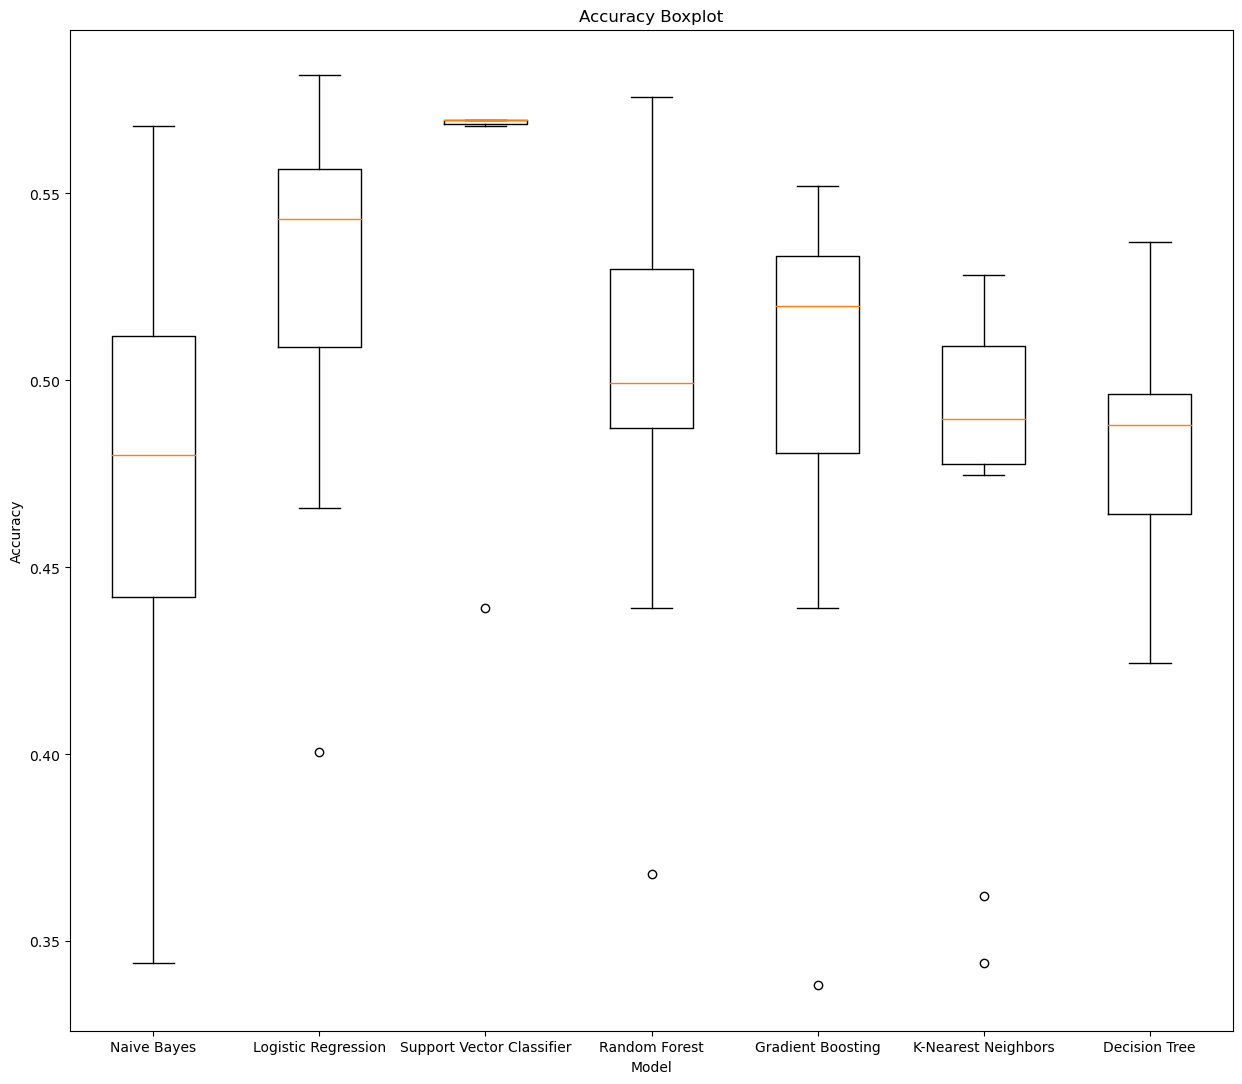

In [86]:
fig, ax = plt.subplots(figsize=(15, 13))
ax.boxplot(cross_score_accuracy)
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(model_names)
ax.set_title("Accuracy Boxplot")

Text(0.5, 1.0, 'F1 Score Boxplot')

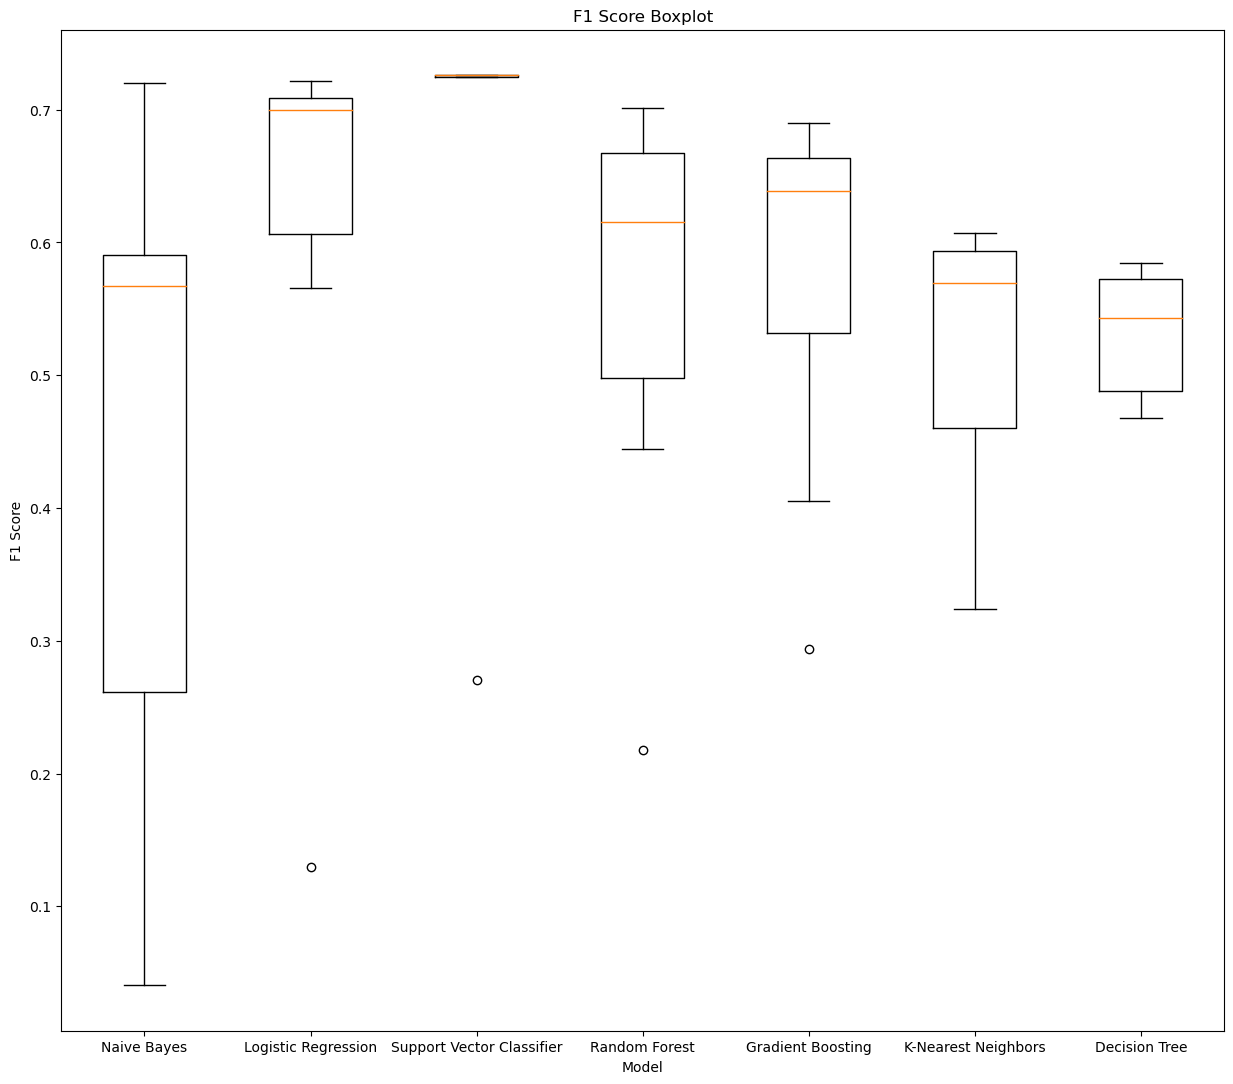

In [88]:
fig, ax = plt.subplots(figsize=(15, 13))
ax.boxplot(cross_score_f1)
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(model_names)
ax.set_title("F1 Score Boxplot")

In [82]:
# Print the results
df_result = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
for result in results:
    row = pd.DataFrame({"Model": [result[0]], "Accuracy": [result[1]*100], "Precision": [result[2]*100], "Recall": [result[3]*100], "F1 Score": [result[4]*100]})
    df_result = pd.concat([df_result, row], ignore_index=True)

df_result.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
1,Logistic Regression,60.592593,61.500000,91.336634,73.505976
2,Support Vector Classifier,59.851852,59.851852,100.000000,74.884152
3,Random Forest,59.111111,62.648221,78.465347,69.670330
4,Gradient Boosting,57.481481,61.676647,76.485149,68.287293
0,Naive Bayes,55.703704,63.027295,62.871287,62.949195
6,Decision Tree,55.111111,63.254593,59.653465,61.401274
5,K-Nearest Neighbors,52.888889,60.436893,61.633663,61.029412


In [83]:
for report, model in zip(reports, model_names):
    print("Model: ", model)
    print("Classification Report:")
    print(report)
    print("//////////////////////////////////////////////////////////")

Model:  Naive Bayes
Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.45      0.45       271
         1.0       0.63      0.63      0.63       404

    accuracy                           0.56       675
   macro avg       0.54      0.54      0.54       675
weighted avg       0.56      0.56      0.56       675

//////////////////////////////////////////////////////////
Model:  Logistic Regression
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.15      0.23       271
         1.0       0.61      0.91      0.74       404

    accuracy                           0.61       675
   macro avg       0.57      0.53      0.48       675
weighted avg       0.58      0.61      0.53       675

//////////////////////////////////////////////////////////
Model:  Support Vector Classifier
Classification Report:
              precision    recall  f1-score   support

         0.0       0.0

In [84]:
x = pd.read_csv("x.csv")
x

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,62.962963,65.039062,82.425743,72.707424
1,Support Vector Classifier,62.222222,63.279857,87.871287,73.575130
2,Random Forest,61.185185,62.769784,86.386139,72.708333
3,K-Nearest Neighbors,60.000000,67.357513,64.356436,65.822785
4,Gradient Boosting,56.444444,60.338346,79.455446,68.589744
5,Decision Tree,50.518519,58.974359,56.930693,57.934509
6,Naive Bayes,46.962963,60.952381,31.683160,41.693811


In [85]:
y = df_result.sort_values('Accuracy', ascending=False)
y

,Model,Accuracy,Precision,Recall,F1 Score
1,Logistic Regression,60.592593,61.500000,91.336634,73.505976
2,Support Vector Classifier,59.851852,59.851852,100.000000,74.884152
3,Random Forest,59.111111,62.648221,78.465347,69.670330
4,Gradient Boosting,57.481481,61.676647,76.485149,68.287293
0,Naive Bayes,55.703704,63.027295,62.871287,62.949195
6,Decision Tree,55.111111,63.254593,59.653465,61.401274
5,K-Nearest Neighbors,52.888889,60.436893,61.633663,61.029412
